<a href="https://colab.research.google.com/github/ElenaBianchini/ColoringGrayscaleImages/blob/main/ProgettoLabIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Progetto di Laboratorio di Intelligenza Artificiale e Grafica Interattiva**

# Import

In [3]:
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchvision 
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skimage import color
from PIL import Image
import pickle
from tqdm import tqdm
from torchsummary import summary

# Impostazione dei parametri

In [5]:
num_epochs = 6
batch_size = 32
learning_rate = 1e-5
use_gpu = torch.cuda.is_available()

In [6]:
if use_gpu:
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

In [7]:
device

device(type='cpu')

# Paths 

In [38]:
root_path = "/content/drive/MyDrive/ProgettoLab"

In [39]:
df = pd.read_csv(f"{root_path}/Places/files.csv",header=0, sep=',')

In [40]:
len(df)

238136

In [41]:
def loadImages(intervallo):
  name_list=[]
  count = 1
  for i in intervallo:
    name_list.append(df.iloc[i])
    print("\rImage num: {}".format(count), end='')
    count+=1
  
  return name_list


In [42]:
intervallo_t = range(1,8001) # 8000 img
train_list = loadImages(intervallo_t)

Image num: 8000

In [43]:
intervallo_v = range(8001, 10001) # 2000 img
val_list = loadImages(intervallo_v)

Image num: 2000

In [44]:
intervallo_te = range(10001,11001) # 1000 img
test_list = loadImages(intervallo_te)

Image num: 1000

# Dataset 

In [45]:
class ImageDataset(torch.utils.data.Dataset):
  def __init__(self, images_list):
    self.images_list = images_list
    self.img_transform = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
    ])

  def __len__(self):
    return len(self.images_list)
  
  def __getitem__(self, idx):
    path, classe = self.images_list[idx]
    path = f"/content/drive/MyDrive/ProgettoLab/Places/{path}"
    
    img = Image.open(path).convert('RGB')
    img = self.img_transform(img)
    img = np.array(img)

    img_lab = color.rgb2lab(img) # restituisce un numpy
    img_lab = (img_lab + 128) / 255   # perché i valori dei canali ab del formato Lab vanno da -128 a 127 e li vogliamo tra [0,1]
    
    img_ab = img_lab[:, :, 1:3] # forma: WxHxC = [224, 224, 2]
    img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float() # forma: CxWxH = [2, 224, 224]
    
    img_gray = color.rgb2gray(img)
    img_gray = torch.from_numpy(img_gray).unsqueeze(0).float()
    
    img = torch.from_numpy(img.transpose((2, 0, 1))).float()
    
    return img, img_ab, img_gray, classe

In [46]:
train_dataset = ImageDataset(train_list)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [47]:
val_dataset = ImageDataset(val_list)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [48]:
test_dataset = ImageDataset(test_list)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Regressione

## Modello

In [49]:
class ColorizationRNet(nn.Module):
  def __init__(self, input_size = 128):
    super(ColorizationRNet, self).__init__()

    # Importo ResNet che userò per estrarre le features dalle immagini
    resnet = torchvision.models.resnet18(num_classes=205)
    #resnet = torchvision.models.resnet18()
    # Cambio il primo livello di convoluzione di ResNet per accettare input con un solo canale
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # Estraggo le feature dalle immagini
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    # Livelli di deconvoluzione:
    self.deconv = nn.Sequential(
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Upsample(scale_factor=2),
        nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Upsample(scale_factor=2),
        nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
        nn.Upsample(scale_factor=2)
    )

  def forward(self, x):
    x = self.midlevel_resnet(x)
    output = self.deconv(x)
    return output

In [50]:
reg_net = ColorizationRNet()
reg_net = reg_net.to(device)

In [51]:
summary(reg_net,input_size=(1,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## Funzione di costo e di ottimizzazione

In [52]:
optimizer = torch.optim.Adam(params=reg_net.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
criterion = criterion.to(device)

## Tracciare i risultati

In [53]:
!pip install wandb
import wandb

wandb.login()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [54]:
wandb.init(project="Lab")

Training loss,▃▁▂▃▃█▃▁▄▃▂▃
Training loss,0.11006


## Train 

In [55]:
def train(epoch, loss_avg):
  # Set model to training model
  reg_net.train()

  print('\nStarting training epoch {}\n'.format(epoch))

  loss_avg.append(0)

  wandb.watch(reg_net, log_freq=10)

  batch_idx=0
  for (img, img_ab, img_gray, classe) in tqdm(train_dataloader):  
    img = img.to(device)
    img_ab = img_ab.to(device)
    img_gray = img_gray.to(device)
    classe = classe.to(device)

    # Predizione dell'immagine ab da grayscale
    predicted = reg_net(img_gray)
  
    # Calcolo l'errore L2 tra i colori ottenuti e quelli veri:
    loss = criterion(predicted, img_ab)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()

    # Aggiorno i pesi:
    optimizer.step()

    loss_avg[-1]+=loss.item()*img.size(0)

    if batch_idx==0: 
      plt.clf() #clear matplotlib
      input_gray = img_gray[0].cpu().squeeze().numpy()
      output_color = torch.cat((img_gray[0].cpu(), predicted[0].detach().cpu()), 0).numpy()
      output_color = output_color.transpose((1,2,0))
      output_color[:, :, 0:1] = output_color[:, :, 0:1] * 100
      output_color[:, :, 1:3] = output_color[:, :, 1:3] * 255 - 128   
      output_color = color.lab2rgb(output_color.astype(np.float64))
      real_color = img[0].cpu().numpy().transpose((1,2,0)).astype(np.uint8)
      plt.imsave(arr=input_gray, fname = '/content/drive/MyDrive/ProgettoLab/Regression/train/{}_grayscale.jpg'.format(epoch),  cmap='gray')
      plt.imsave(arr=output_color, fname = '/content/drive/MyDrive/ProgettoLab/Regression/train/{}_recolored.jpg'.format(epoch))
      plt.imsave(arr=real_color, fname = '/content/drive/MyDrive/ProgettoLab/Regression/train/{}_real.jpg'.format(epoch))


    if batch_idx % 10 == 0:
        wandb.log({"Training loss": loss*img.size(0)})
        
    batch_idx+=1

  loss_avg[-1]/= len(train_dataloader)
  print('\nTrain set: Average loss: {:.6f}\n'.format(train_loss_avg[-1]))
  print('Finished training epoch {}\n'.format(epoch))


## Validation 

In [56]:
def validation(epoch, val_loss_avg):
  # Set model to validation model
  reg_net.eval()

  val_loss_avg.append(0)
  
  print("\nValidation: {}\n".format(epoch))
  
  wandb.watch(reg_net, log_freq=10)

  batch_idx=0
  for (img, img_ab, img_gray,classe) in tqdm(val_dataloader):  
    img = img.to(device)
    img_ab = img_ab.to(device)
    img_gray = img_gray.to(device)
    classe = classe.to(device)

    # Predizione dell'immagine ab da grayscale
    predicted = reg_net(img_gray)

    # Calcolo l'errore L2 tra i colori ottenuti e quelli veri:
    loss = criterion(predicted, img_ab)
    val_loss_avg[-1]+=loss.item()*img.size(0)

    # Salvo la prima foto di ogni epoca
    if batch_idx==0: 
      plt.clf() #clear matplotlib
      input_gray = img_gray[0].cpu().squeeze().numpy()
      output_color = torch.cat((img_gray[0].cpu(), predicted[0].detach().cpu()), 0).numpy()
      output_color = output_color.transpose((1,2,0))
      output_color[:, :, 0:1] = output_color[:, :, 0:1] * 100
      output_color[:, :, 1:3] = output_color[:, :, 1:3] * 255 - 128   
      output_color = color.lab2rgb(output_color.astype(np.float64))
      real_color = img[0].cpu().numpy().transpose((1,2,0)).astype(np.uint8)
      plt.imsave(arr=input_gray, fname = '/content/drive/MyDrive/ProgettoLab/Regression/immagini/{}_grayscale.jpg'.format(epoch),  cmap='gray')
      plt.imsave(arr=output_color, fname = '/content/drive/MyDrive/ProgettoLab/Regression/immagini/{}_recolored.jpg'.format(epoch))
      plt.imsave(arr=real_color, fname = '/content/drive/MyDrive/ProgettoLab/Regression/immagini/{}_real.jpg'.format(epoch))

    if batch_idx % 5 == 0:
      wandb.log({"Validation loss": loss*img.size(0)})
    
    batch_idx+=1

  val_loss_avg[-1]/= len(val_dataloader)
  print('\nValidation set: Average loss: {:.6f}\n'.format(val_loss_avg[-1]))


## Allenamento

In [ ]:
# Carico il modello preallenato per incrementare i risultati
pretrained = torch.load('/content/drive/MyDrive/ProgettoLab/Regression/checkpoints/1-lr10-5.pth', map_location = torch.device("cpu"))
reg_net.load_state_dict(pretrained)
reg_net = reg_net.to(device)

In [57]:
import datetime
import warnings
warnings.filterwarnings("ignore") #disabilito i warning per avere una stampa più pulita

train_loss_avg = []
val_loss_avg = []

d = datetime.datetime.now()
day = d.strftime("%d")
month = d.strftime("%m")
data = day+'-'+month

for epoch in range(1, num_epochs+1):
  train(epoch, train_loss_avg)
  with torch.no_grad():
    validation(epoch, val_loss_avg)

  torch.save(reg_net.state_dict(), '/content/drive/MyDrive/ProgettoLab/Regression/checkpoints/1-lr10-5.pth')

path_train = f"{root_path}/Regression/logs/{data}.pkl"
with open(path_train, 'wb') as f:
  pickle.dump({"train": train_loss_avg, "validate":val_loss_avg}, f)



Starting training epoch 1



100%|██████████| 250/250 [36:48<00:00,  8.84s/it]



Train set: Average loss: 4.528614

Finished training epoch 1


Validation: 1



100%|██████████| 63/63 [12:13<00:00, 11.64s/it]



Validation set: Average loss: 1.074353


Starting training epoch 2



100%|██████████| 250/250 [34:22<00:00,  8.25s/it]



Train set: Average loss: 0.532792

Finished training epoch 2


Validation: 2



100%|██████████| 63/63 [03:15<00:00,  3.10s/it]



Validation set: Average loss: 0.268962


Starting training epoch 3



100%|██████████| 250/250 [34:13<00:00,  8.22s/it]



Train set: Average loss: 0.219566

Finished training epoch 3


Validation: 3



100%|██████████| 63/63 [03:13<00:00,  3.07s/it]



Validation set: Average loss: 0.172539


Starting training epoch 4



100%|██████████| 250/250 [34:25<00:00,  8.26s/it]



Train set: Average loss: 0.170064

Finished training epoch 4


Validation: 4



100%|██████████| 63/63 [03:12<00:00,  3.06s/it]



Validation set: Average loss: 0.150110


Starting training epoch 5



100%|██████████| 250/250 [34:03<00:00,  8.17s/it]



Train set: Average loss: 0.150515

Finished training epoch 5


Validation: 5



100%|██████████| 63/63 [03:11<00:00,  3.04s/it]



Validation set: Average loss: 0.135563


Starting training epoch 6



100%|██████████| 250/250 [33:55<00:00,  8.14s/it]



Train set: Average loss: 0.138054

Finished training epoch 6


Validation: 6



100%|██████████| 63/63 [03:10<00:00,  3.02s/it]


Validation set: Average loss: 0.124407



<Figure size 432x288 with 0 Axes>

## Grafico della curva di apprendimento

In [ ]:
# Valori dell'ultimo allenamento:
ultimo = '/content/drive/MyDrive/ProgettoLab/Regression/logs/09-06.pkl'

f = open(ultimo,'rb')
d = pickle.load(f)

train_loss_avg = []
val_loss_avg = []

for loss in d['train']:
  train_loss_avg.append(loss)

for loss in d['validate']:
  val_loss_avg.append(loss)


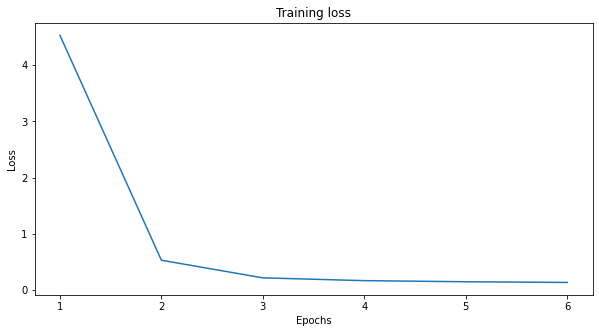

In [61]:
plt.ion()
fig = plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, num_epochs+1),train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

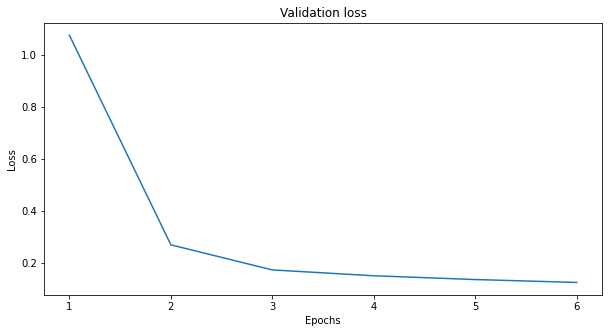

In [62]:
plt.ion()
fig = plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, num_epochs+1), val_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation loss')
plt.show()

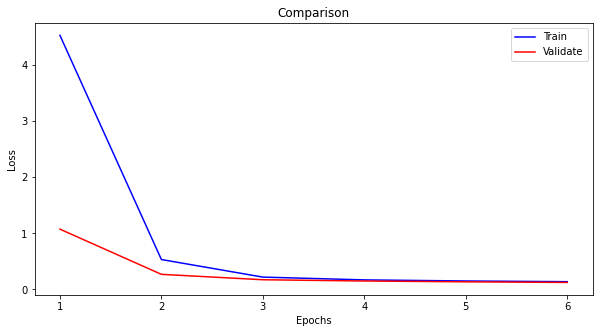

In [63]:
plt.ion()
fig = plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, num_epochs+1),train_loss_avg, 'b', label='Train')
plt.plot(np.arange(1, num_epochs+1), val_loss_avg, 'r', label='Validate')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison')
plt.legend()
plt.show()

## Grafico della curva di apprendimento di tutte le epoche allenate

## Risultati sulle immagini del Validation Set


Epoca: 1



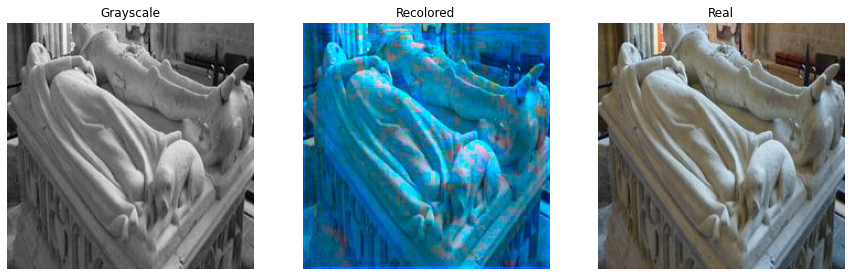


Epoca: 2



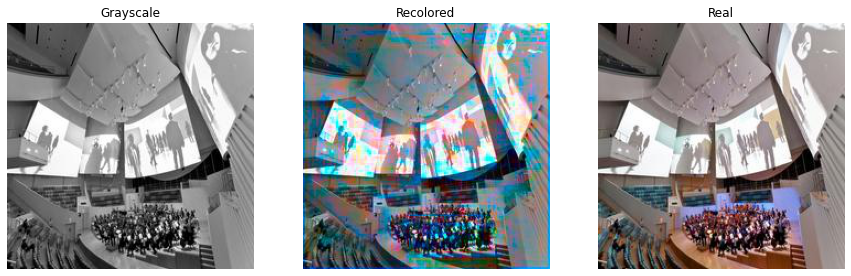


Epoca: 3



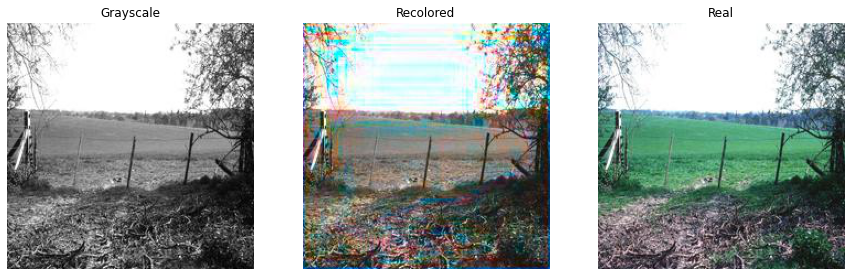


Epoca: 4



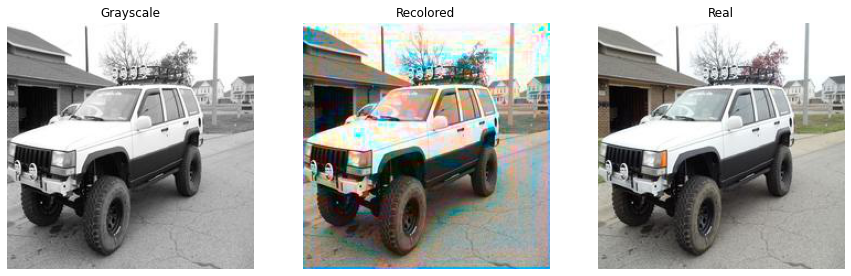


Epoca: 5



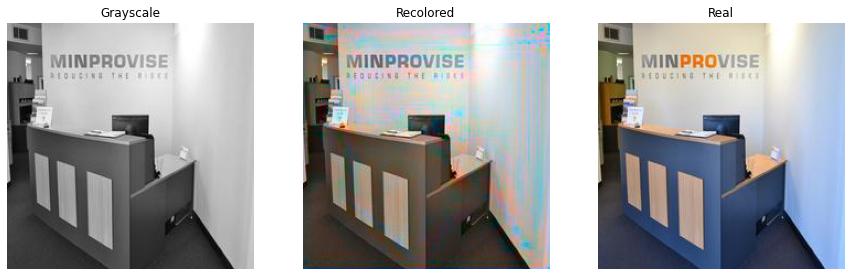


Epoca: 6



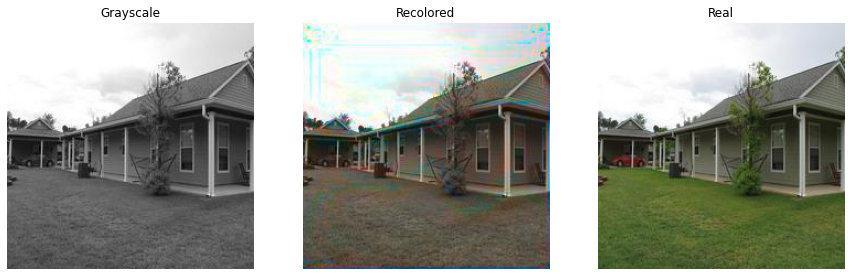

In [8]:
path = '/content/drive/MyDrive/ProgettoLab/Regression/immagini/'

for i in range(1,num_epochs+1):
  print('\nEpoca: {}\n'.format(i))
  gray = Image.open(path+'{}_grayscale.jpg'.format(i))
  recolored = Image.open(path+'{}_recolored.jpg'.format(i))
  real = Image.open(path+'{}_real.jpg'.format(i))

  f, ax = plt.subplots(1,3)
  f.set_size_inches(15, 15)

  ax[0].imshow(gray, cmap='gray')
  ax[0].set_title('Grayscale')

  ax[1].imshow(recolored)
  ax[1].set_title('Recolored')

  ax[2].imshow(real)
  ax[2].set_title('Real')

  ax[0].axis('off'),ax[1].axis('off'), ax[2].axis('off')

  plt.show()

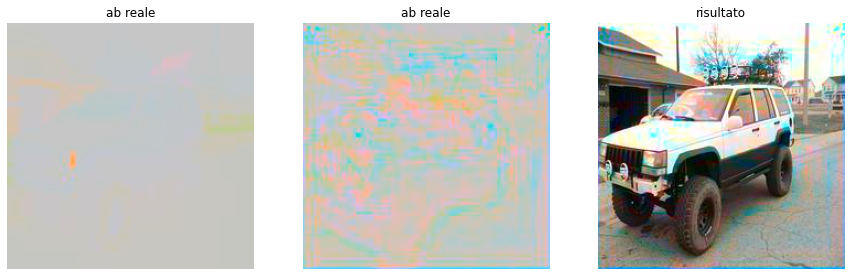

In [10]:
path = '/content/drive/MyDrive/ProgettoLab/Regression/immagini/'

epoch = 4

recolored = Image.open(path+'{}_recolored.jpg'.format(epoch))
real = Image.open(path+'{}_real.jpg'.format(epoch))

gray = color.rgb2gray(np.array(real)).reshape((224,224))
gray = gray*100

lab_predicted = (color.rgb2lab(recolored)+128)/255
lab_real = (color.rgb2lab(real)+128)/255

ab_predicted = lab_predicted[:,:,1:3]
ab_real = lab_real[:,:,1:3]

ab_p = np.zeros((224,224,3))
ab_p[:,:,0]=80
ab_predicted = ab_predicted*255 - 128
ab_p[:,:,1:3] = ab_predicted
ab_p = color.lab2rgb(ab_p)

ab_r = np.zeros((224,224,3))
ab_r[:,:,0]=80
ab_real = ab_real*255 - 128
ab_r[:,:,1:3] = ab_real
ab_r = color.lab2rgb(ab_r)

output_color = np.zeros((224,224,3))
output_color[:,:,0]= gray
output_color[:,:,1:3]=ab_predicted
output_color = color.lab2rgb(output_color)

f, ax = plt.subplots(1,3)
f.set_size_inches(15, 15)
ax[0].imshow(ab_r)
ax[1].imshow(ab_p)
ax[2].imshow(output_color)
ax[0].set_title("ab reale")
ax[1].set_title("ab reale")
ax[2].set_title("risultato")
ax[0].axis('off'),ax[1].axis('off'),ax[2].axis('off')
plt.show()

